In [13]:
import codecs
import numpy as np
import gensim
import pandas as pd
from scipy import stats as st

### Task 1

In [3]:
with codecs.open('sapiens.txt', encoding='utf-8', mode='r') as f:    
    docs = f.readlines()

sentences = [[word for word in sent.lower().split()] for sent in docs]
print(len(sentences), 'предложений')

FileNotFoundError: [Errno 2] No such file or directory: 'sapiens.txt'

In [ ]:
word_model = gensim.models.Word2Vec(sentences, vector_size=100, min_count=1, window=5, epochs=100)

In [ ]:
pretrained_weights = word_model.wv.vectors
vocab_size, embedding_size = pretrained_weights.shape
print(vocab_size, embedding_size)

In [ ]:
print('Похожие слова:')
for word in ['god', 'human', 'evolution', 'sapiens', 'weed', 'humankind', 'species']:
    most_similar = ', '.join('%s (%.2f)' % (similar, dist) for similar, dist in word_model.wv.most_similar(word)[:8])
    print('  %s -> %s' % (word, most_similar))

### Task 2 

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

df = pd.read_csv('./data/production.csv')
df.head()

,API,Year,Month,Liquid,Gas,RatioGasOil,Water,PercentWater,DaysOn,_LastUpdate
0,5005072170100,2014,11,9783,11470,1.172442,10558,1.079219,14,2016-04-06 17:20:05.757
1,5005072170100,2014,12,24206,26476,1.093778,5719,0.236264,31,2016-04-06 17:20:05.757
2,5005072170100,2015,1,20449,26381,1.290088,2196,0.107389,31,2016-04-06 17:20:05.757
3,5005072170100,2015,2,6820,10390,1.523460,583,0.085484,28,2016-04-06 17:20:05.757
4,5005072170100,2015,3,7349,7005,0.953191,122,0.016601,13,2016-06-16 14:07:33.203


In [34]:
liquid = df.groupby('API')[['Liquid', "Gas", "Water"]].apply(lambda df_: df_.reset_index(drop=True))
liquid.head()

Liquid    Gas  Water
API                                  
5005072170100 0    9783  11470  10558
              1   24206  26476   5719
              2   20449  26381   2196
              3    6820  10390    583
              4    7349   7005    122

In [16]:
liquid['Liquid'] = liquid['Liquid'] / liquid['Liquid'].max()
liquid['Gas'] = liquid['Gas'] / liquid['Gas'].max()
liquid['Water'] = liquid['Water'] / liquid['Water'].max()

In [37]:
liquid.iloc[0]

Liquid     9783
Gas       11470
Water     10558
Name: (5005072170100, 0), dtype: int64

In [38]:
#model(torch.tensor(liquid.iloc[0].to_numpy().reshape(1,1,3).astype(np.float32)))

In [39]:
data = liquid.to_numpy()
data = data.reshape((50,24,3))

In [40]:
data.shape

(50, 24, 3)

In [41]:
data_tr = data[:40]
data_tst = data[40:]
print(data_tr.shape, data_tst.shape)

(40, 24, 3) (10, 24, 3)


In [42]:
x_data = [data_tr[:, i:i+12] for i in range(11)]
y_data = [data_tr[:, i+1:i+13] for i in range(11)]

x_data = np.concatenate(x_data, axis=0)
y_data = np.concatenate(y_data, axis=0)
print(x_data.shape, y_data.shape)

(440, 12, 3) (440, 12, 3)


In [43]:
tensor_x = torch.Tensor(x_data) # transform to torch tensor
tensor_y = torch.Tensor(y_data)

oil_dataset = TensorDataset(tensor_x,tensor_y) # create your datset
oil_dataloader = DataLoader(oil_dataset, batch_size=16) # create your dataloader

In [44]:
for x_t, y_t in oil_dataloader:
    break
x_t.shape, y_t.shape

(torch.Size([16, 12, 3]), torch.Size([16, 12, 3]))

In [25]:
class OilModel(nn.Module):
    def __init__(self, timesteps=12, units=32):
        super().__init__()
        self.lstm1 = nn.LSTM(3, units, 2, batch_first=True)
        self.dense = nn.Linear(units, 3)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        h, _ = self.lstm1(x)
        outs = []
        for i in range(h.shape[0]):
            outs.append(self.relu(self.dense(h[i])))
        #print(outs)
        out = torch.stack(outs, dim=0)
        return out

In [26]:
model = OilModel()
opt = optim.Adam(model.parameters())
criterion = nn.MSELoss()

In [32]:
NUM_EPOCHS = 80

for epoch in range(NUM_EPOCHS):  # loop over the dataset multiple times

    running_loss = 0.0
    num = 0
    for x_t, y_t in oil_dataloader:
        # zero the parameter gradients
        opt.zero_grad()

        # forward + backward + optimize
        outputs = model(x_t)
        loss = criterion(outputs, y_t)
        loss.backward()
        opt.step()

        # print statistics
        running_loss += loss.item()
        num += 1
        print(outputs.shape)
    print(f'[Epoch: {epoch + 1:2d}] loss: {running_loss / num:.3f}')
print('Finished Training')

torch.Size([16, 12, 3])
torch.Size([16, 12, 3])
torch.Size([16, 12, 3])
torch.Size([16, 12, 3])
torch.Size([16, 12, 3])
torch.Size([16, 12, 3])
torch.Size([16, 12, 3])
torch.Size([16, 12, 3])
torch.Size([16, 12, 3])
torch.Size([16, 12, 3])
torch.Size([16, 12, 3])
torch.Size([16, 12, 3])
torch.Size([16, 12, 3])
torch.Size([16, 12, 3])
torch.Size([16, 12, 3])
torch.Size([16, 12, 3])
torch.Size([16, 12, 3])
torch.Size([16, 12, 3])
torch.Size([16, 12, 3])
torch.Size([16, 12, 3])
torch.Size([16, 12, 3])
torch.Size([16, 12, 3])
torch.Size([16, 12, 3])
torch.Size([16, 12, 3])
torch.Size([16, 12, 3])
torch.Size([16, 12, 3])
torch.Size([16, 12, 3])
torch.Size([8, 12, 3])
[Epoch:  1] loss: 0.002
torch.Size([16, 12, 3])
torch.Size([16, 12, 3])
torch.Size([16, 12, 3])
torch.Size([16, 12, 3])
torch.Size([16, 12, 3])
torch.Size([16, 12, 3])
torch.Size([16, 12, 3])
torch.Size([16, 12, 3])
torch.Size([16, 12, 3])
torch.Size([16, 12, 3])
torch.Size([16, 12, 3])
torch.Size([16, 12, 3])
torch.Size([16, 1

In [46]:
x_tst = data_tst[:, :12]
predicts = np.zeros((x_tst.shape[0], 0, x_tst.shape[2]))
print(x_tst.shape)

for i in range(12):
    x = np.concatenate((x_tst[:, i:], predicts), axis=1)
    x_t = torch.from_numpy(x).float()
    print(x_t.shape)
    pred = model(x_t).detach().numpy()
    last_pred = pred[:, -1:]  # Нас интересует только последний месяц
    predicts = np.concatenate((predicts, last_pred), axis=1)
predicts

(10, 12, 3)
torch.Size([10, 12, 3])
torch.Size([10, 12, 3])
torch.Size([10, 12, 3])
torch.Size([10, 12, 3])
torch.Size([10, 12, 3])
torch.Size([10, 12, 3])
torch.Size([10, 12, 3])
torch.Size([10, 12, 3])
torch.Size([10, 12, 3])
torch.Size([10, 12, 3])
torch.Size([10, 12, 3])
torch.Size([10, 12, 3])


array([[[0.67277342, 0.86228055, 0.        ],
        [0.77526271, 0.91639537, 0.        ],
        [0.85491502, 1.00337625, 0.        ],
        [0.90220416, 1.01241195, 0.        ],
        [0.94061327, 1.00198984, 0.        ],
        [0.97856969, 1.0092442 , 0.        ],
        [0.94600654, 0.89840931, 0.        ],
        [0.94884872, 0.89161748, 0.        ],
        [0.86176848, 0.9397788 , 0.        ],
        [0.76162422, 0.98380059, 0.        ],
        [0.7205838 , 1.01930153, 0.        ],
        [0.59143162, 1.01159179, 0.        ]],

       [[0.73662937, 1.01768994, 0.        ],
        [0.81650853, 0.90735281, 0.        ],
        [0.8765648 , 0.99729353, 0.        ],
        [0.97123778, 1.01275921, 0.        ],
        [1.0007993 , 0.97182351, 0.        ],
        [1.00162971, 0.94166249, 0.        ],
        [0.9627099 , 0.9210307 , 0.        ],
        [0.90032351, 0.89958364, 0.        ],
        [0.85373819, 0.93554544, 0.        ],
        [0.78375876, 0.97720557,

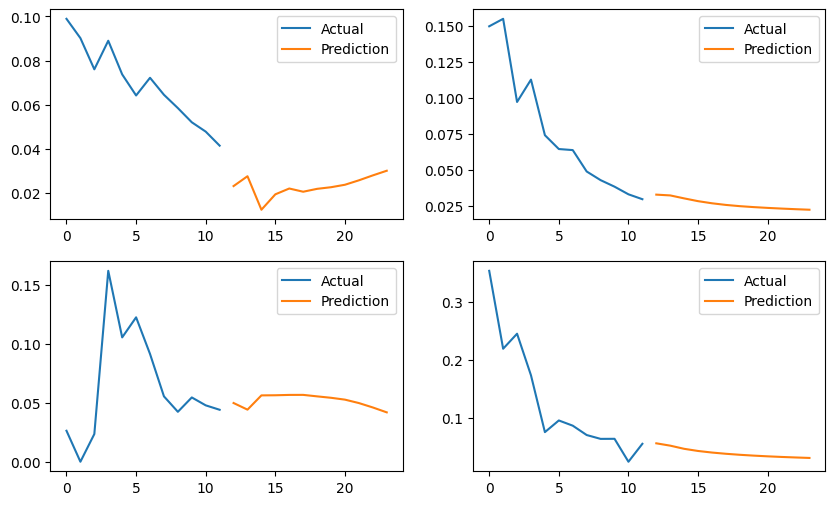

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for iapi in range(4):
    plt.subplot(2, 2, iapi+1)
    plt.plot(np.arange(x_tst.shape[1]), x_tst[iapi, :, 0], label='Actual')
    plt.plot(np.arange(predicts.shape[1])+x_tst.shape[1], predicts[iapi, :, 0], label='Prediction')
    plt.legend()
plt.show()

### task3

In [40]:
with codecs.open('sapiens.txt', encoding='utf-8', mode='r') as f:    
    docs_part = f.readlines()

sentences_part = [[word for word in sent.lower().split()] for sent in docs]
print(len(sentences), 'предложений')

4937 предложений


In [41]:
sentences_part = [sent for sent in sentences_part if len(sent) != 0]

In [42]:
sentences_lens = np.array(list(map(sum, [map(len, sent) for sent in sentences_part])))
st.mode(sentences_lens)

ModeResult(mode=12, count=21)

In [43]:
sentences_part_same = [sent for sent in sentences_part if sum(map(len, sent)) == 12]
sentences_part_same = np.array([list(''.join(sent)) for sent in sentences_part_same])
sentences_part_same

array([['i', 'm', 'a', 'g', 'e', 'c', 'r', 'e', 'd', 'i', 't', 's'],
       ['e', 'x', 't', 'i', 'n', 'c', 't', 'i', 'o', 'n', 'o', 'f'],
       ['a', 'r', 'a', 'c', 'e', 'o', 'f', 'c', 'o', 'o', 'k', 's'],
       ['s', 'i', 'g', 'n', 'e', 'd', 'k', 'u', 's', 'h', 'i', 'm'],
       ['a', 'n', 'd', 'h', 'e', 'c', 'a', 'n', 'e', 'd', 'm', 'e'],
       ['a', 'n', 'd', 'h', 'e', 'c', 'a', 'n', 'e', 'd', 'm', 'e'],
       ['a', 'n', 'd', 'h', 'e', 'c', 'a', 'n', 'e', 'd', 'm', 'e'],
       ['a', 'n', 'd', 'h', 'e', 'c', 'a', 'n', 'e', 'd', 'm', 'e'],
       ['a', 'n', 'd', 'h', 'e', 'c', 'a', 'n', 'e', 'd', 'm', 'e'],
       ['a', 'n', 'd', 'h', 'e', 'c', 'a', 'n', 'e', 'd', 'm', 'e'],
       ['s', 'e', 'x', 'a', 'n', 'd', 'g', 'e', 'n', 'd', 'e', 'r'],
       ['o', 'f', 'm', 'i', 'c', 'e', 'a', 'n', 'd', 'm', 'e', 'n'],
       ['i', 'm', 'a', 'g', 'e', 'c', 'r', 'e', 'd', 'i', 't', 's'],
       ['v', 'i', 's', 'u', 'a', 'l', 'c', 'o', 'r', 'b', 'i', 's'],
       ['v', 'i', 's', 'u', 'a', '

In [54]:
np.unique(sentences_part_same)
alphabet = {}
for i, letter in enumerate(np.unique(sentences_part_same)):
    arr = [0] * len(np.unique(sentences_part_same))
    arr[i] = 1
    alphabet[letter] = arr
alphabet

{'a': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'b': [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'c': [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'd': [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'e': [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'f': [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'g': [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'h': [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'i': [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'k': [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'l': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'm': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 'n': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 'o': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
 'r': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [55]:
sent_list = np.ndarray.tolist(sentences_part_same)
for i in range(len(sent_list)):
    for j in range(len(sent_list[0])):
        sent_list[i][j] = alphabet[sent_list[i][j]]

In [57]:
sent_arr = np.array(sent_list)
sent_arr.shape

(21, 12, 20)

### Task 4